In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from ast import literal_eval
from surprise import *
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
import streamlit as st
from PIL import Image
from collections import defaultdict

In [ ]:

if 'total' not in st.session_state:
    st.session_state['total'] = 300


st.header("Telco Recs - Cross Selling Packages recommender")
st.write("Recommendations predicteed using collabarative Filtering approaches")


img=Image.open("data/fm_data/main.png")

st.image(img,width=800)


In [114]:
user_profile = pd.read_csv("data/User_Profile_Null_Handled.csv")

In [115]:
user_profile["Sub_Update_Status"].value_counts()

NO_INFO                30250
Promotion Upgrade       7369
Promotion Downgrade     4975
Name: Sub_Update_Status, dtype: int64

In [116]:
data=user_profile.iloc[:,[1,3,11,14,18,23,25,43,48,53,59,61,34]]
#data.rename(columns={"Sub_Type":"label"},inplace=True)
data = pd.get_dummies(data, prefix=['Sub_Update'], columns=['Sub_Update_Status'])
# data.drop('Sub_Update_Status', axis=1)

# Label encode class
# le = LabelEncoder()
# data['label'] = le.fit_transform(data.Sub_Type.values)
data = data.drop(['Sub_Update_NO_INFO'], axis=1)

In [117]:
data.fillna(0,inplace=True)
data_dim=data.iloc[:,[1,2,3,4,5,6,7,8,9,10,12,13]]

## PCA Based rating calculation

In [118]:
pc=PCA(n_components=12) 
pc.fit(data_dim)

PCA(n_components=12)

In [119]:
#How mucb variance, captured together
pc.explained_variance_ratio_.cumsum()

array([0.31595666, 0.56946394, 0.72630511, 0.86585636, 0.93064071,
       0.96783583, 0.98094293, 0.98846729, 0.99519398, 0.99953125,
       0.99995611, 1.        ])

In [120]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
pca = PCA(n_components=1)
pca.fit(data_dim)
reduced_data = pca.fit_transform(data_dim)
results_df = pd.DataFrame(reduced_data,columns=['ratings'])

In [121]:
# applying min-max-scaler to reduced features
scaler = MinMaxScaler()
results_df[['ratings']] = scaler.fit_transform(results_df[['ratings']])

In [122]:
data=pd.concat([data,results_df],axis=1)

In [123]:
data.rename(columns={"Sub_Type":"package"}, inplace=True)
data = data[["ACCOUNT_NUM.hash","package","ratings"]]
data

,ACCOUNT_NUM.hash,package,ratings
0,9efd917f18bb5c966953b4227ddbaf43,TRIPLE_PLAY,0.403696
1,2240d11b0d9ee8f6d9e8972c6190aa42,SINGLE_PLAY,0.251039
2,cff00495fd556a417e2838e27465d749,DOUBLE_PLAY_BV,0.374582
3,d00dacd8fc98c1726d6a4e9f28f8e579,TRIPLE_PLAY,0.301764
4,a3ee54787617510a616dfcb52c28941b,TRIPLE_PLAY,0.384823
...,...,...,...
42589,7052930957f02ad914dbd24fdcd04fed,DOUBLE_PLAY_BV,0.399498
42590,c217fb1b44642e79e56af9111e9c00b2,TRIPLE_PLAY,0.879634
42591,5e94646aa83bb9d7fab98620405517cb,DOUBLE_PLAY_BV,0.247882
42592,6801a82b67b7fb942242b7aca5ba022c,DOUBLE_PLAY_BV,0.441890


## Interaction Matrix

In [124]:
# create a histogram of all the interactions by all the users present in the dataset
def create_interaction_matrix(data):
    interactions = data.groupby('ACCOUNT_NUM.hash').count()['package']
    plt.hist(interactions,bins=20)
    plt.show()

    # create the user item matrix using the ratings dataset - Hint: try using pivot function 
    interactions_metrix = data.pivot_table(index="ACCOUNT_NUM.hash", columns="package", values="ratings",aggfunc=np.sum)
    # replace all the missing values with zero
    return interactions_metrix.fillna(0)

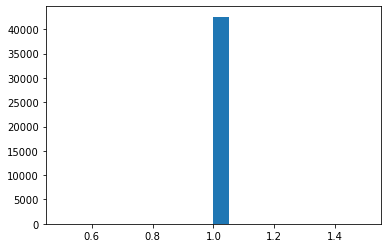

package,4G,DOUBLE_PLAY_BV,DOUBLE_PLAY_PV,SINGLE_PLAY,TRIPLE_PLAY
ACCOUNT_NUM.hash,,,,,
0003102d10a11c8f2f0f241f00a36b2d,0.0,0.000000,0.000000,0.000000,0.713319
0003df7598926f578f53ecd9e424f3c9,0.0,0.330602,0.000000,0.000000,0.000000
00092b1fd47eb05d000a3553ae072056,0.0,0.000000,0.000000,0.000000,0.413539
00094326efae1d73371d118204e12e46,0.0,0.000000,0.343136,0.000000,0.000000
000ae59b7eb91e778f22e3f07495f4f9,0.0,0.416101,0.000000,0.000000,0.000000
...,...,...,...,...,...
fff9148b195a844454cf5b07c2fccbcb,0.0,0.000000,0.090593,0.000000,0.000000
fffaeeddaabbd2868c183d8884b2a98d,0.0,0.000000,0.000000,0.000000,0.449490
fffd0b8541e9f62496092d2ea8609135,0.0,0.000000,0.000000,0.000000,0.514746


In [125]:
create_interaction_matrix(data)

In [126]:
#X = interactions_metrix.values.T

## Function definition

In [127]:
def train_test_splitter(data):
    reader = Reader(rating_scale=(0, 1))
    data_model = Dataset.load_from_df(data, reader)
    return data_model,train_test_split(data_model, test_size=.20)

In [128]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

In [129]:
def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:5]
        

    return top_n

In [130]:
# calculate NDCG
def ndcg(y_true, y_pred, k=None, powered=False):
    def dcg(scores, k=None, powered=False):
        if k is None:
            k = scores.shape[0]
        if not powered:
            ret = scores[0]
            for i in range(1, k):
                ret += scores[i] / np.log2(i + 1)
            return ret
        else:
            ret = 0
            for i in range(k):
                ret += (2 ** scores[i] - 1) / np.log2(i + 2)
            return ret
    
    ideal_sorted_scores = np.sort(y_true)[::-1]
    ideal_dcg_score = dcg(ideal_sorted_scores, k=k, powered=powered)
    
    pred_sorted_ind = np.argsort(y_pred)[::-1]
    pred_sorted_scores = y_true[pred_sorted_ind]
    dcg_score = dcg(pred_sorted_scores, k=k, powered=powered)
    
    return dcg_score / ideal_dcg_score

def ndcg1(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=False)

def ndcg2(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=True)

In [131]:
def top_n_pred(predictions):
    top_n = get_top_n(predictions, n=3)
    #print(top_n)
    users_est = defaultdict(list)
    users_true=defaultdict(list)
    rec_for_user=defaultdict(list)
    for uid, user_ratings in top_n.items():
        users_est[uid].append([est for (_, est,_) in user_ratings])
        users_true[uid].append([true_r for (_,_,true_r) in user_ratings])
        rec_for_user[uid].append([iid for (iid,_,_) in user_ratings])
    return top_n, users_est, users_true, rec_for_user

In [132]:
def calc_ndcg(users_true,users_est):
    ndcg_list=[]
    for uid in top_n:
        
        for i in users_true[uid]:
            y_true=np.asarray(i)#.reshape(-1,1)
        for i in users_est[uid]:
            y_pred=np.asarray(i)#.reshape(-1,1)
        
            ndcg_list.append(ndcg1(y_true, y_pred, k=None))

    ndcg_list = [i for i in ndcg_list if str(i) != 'nan']
    ndgc_rate = np.mean(ndcg_list)
    return ndcg_list, ndgc_rate

## Collobarative Recommenders

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42594 entries, 0 to 42593
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ACCOUNT_NUM.hash  42594 non-null  object 
 1   package           42594 non-null  object 
 2   ratings           42594 non-null  float64
dtypes: float64(1), object(2)
memory usage: 998.4+ KB


In [134]:
data = data[data["ratings"] > 0]

In [135]:
data_model, (trainset, testset) = train_test_splitter(data)

## SVD Model

In [136]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
svd_validate = cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1761  0.1772  0.1770  0.1759  0.1770  0.1766  0.0005  
MAE (testset)     0.1392  0.1406  0.1402  0.1397  0.1413  0.1402  0.0007  
Fit time          1.96    2.02    2.06    1.98    2.02    2.01    0.04    
Test time         0.05    0.05    0.05    0.05    0.05    0.05    0.00    


In [137]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [138]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

In [139]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 1.0


In [140]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [141]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
583,d225220a97308dd2b52055ddfd6138f7,TRIPLE_PLAY,0.510184,0.510200,{'was_impossible': False},0,12724,0.000016
4659,fc7d8f1a4b36fbc58c8a57dc04a1d0bb,DOUBLE_PLAY_PV,0.368969,0.368928,{'was_impossible': False},0,3064,0.000041
3581,3ff7b2898cc7fbac7101b0aee1e10bfc,DOUBLE_PLAY_BV,0.381766,0.381819,{'was_impossible': False},0,12679,0.000053
230,666dff633dbcc11f1bc254043a016138,TRIPLE_PLAY,0.510310,0.510200,{'was_impossible': False},0,12724,0.000110
7618,acda781c4a8aae80e21291112b3f2603,DOUBLE_PLAY_BV,0.381939,0.381819,{'was_impossible': False},0,12679,0.000121
4887,f2d8e3cf830fa47e3e2cae2b3ca2f0d8,TRIPLE_PLAY,0.510078,0.510200,{'was_impossible': False},0,12724,0.000122
2650,eff9bc2ce5226945cc72ccf67414889e,TRIPLE_PLAY,0.510348,0.510200,{'was_impossible': False},0,12724,0.000148
4336,c189bae2245c7dfda4ca90f3a6d43056,TRIPLE_PLAY,0.510376,0.510200,{'was_impossible': False},0,12724,0.000175
3410,33394a2b6d112bd15af487281b4aab2a,DOUBLE_PLAY_BV,0.381641,0.381819,{'was_impossible': False},0,12679,0.000178
8200,ad5810fea6c4ab228ba60a92ac500988,DOUBLE_PLAY_BV,0.381999,0.381819,{'was_impossible': False},0,12679,0.000180


In [142]:
df.sort_values(by='err').to_csv("data/cross-selling/scored/SVD_Scored.csv")

In [143]:
rmse = accuracy.rmse(predictions)
print("SVD RMSE -->",rmse)
print("SVD Accuracy -->",1-rmse)

RMSE: 0.1754
SVD RMSE --> 0.17536393565496067
SVD Accuracy --> 0.8246360643450393


In [144]:
data_triplet = data.merge(df[["uid","iid","err"]], left_on="ACCOUNT_NUM.hash", right_on ="uid", how="left")
data_triplet.dropna(subset=["uid"],inplace=True)
data_triplet.drop("uid", axis=1, inplace = True)
data_triplet.rename(columns={"package":"Actual_Subscription","iid":"SVD_recommendation","err":"SVD_error"}, inplace = True)

## SlopeOne

In [145]:
# We'll use the SlopeOne algorithm.
algo = SlopeOne()

# Run 5-fold cross-validation and print results
so_validate =cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2025  0.2044  0.2067  0.2038  0.2045  0.2044  0.0014  
MAE (testset)     0.1576  0.1601  0.1621  0.1592  0.1597  0.1597  0.0014  
Fit time          0.33    0.35    0.36    0.34    0.34    0.35    0.01    
Test time         0.06    0.06    0.07    0.06    0.06    0.06    0.00    


In [146]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [147]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

In [148]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 1.0


In [149]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [150]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4092,4613ca7184c740bda13ad868792e6961,TRIPLE_PLAY,0.406970,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12724,0.000004
2415,5993a34742ee50dad92ba27918d202aa,DOUBLE_PLAY_BV,0.406983,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000009
1093,a69f76b793a0f81f6bf03334891a7639,TRIPLE_PLAY,0.406952,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12724,0.000022
7,38c9fc6c82f448802bdf87c0f06687bb,DOUBLE_PLAY_BV,0.406949,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000025
8215,452333afef985e3a381f324cf5f9c03a,DOUBLE_PLAY_BV,0.407041,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000067
5250,9c1b97133c63d72f524e5eccf725eb5f,DOUBLE_PLAY_BV,0.407075,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000101
5359,7911d0c2cdc4b981abb7bbc86d6c042b,TRIPLE_PLAY,0.406826,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12724,0.000148
3098,45e3e7602b24b61f107bdaed331259a2,DOUBLE_PLAY_BV,0.406821,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000153
1901,d1805fca4fcface24d5e9deabd072da4,DOUBLE_PLAY_BV,0.407165,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000191
2695,5a585d43c83a65b0dacc9e895604a50e,DOUBLE_PLAY_BV,0.406755,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000219


In [151]:
df.sort_values(by='err').to_csv("data/cross-selling/scored/SlopeOne_Scored.csv")

In [152]:
rmse = accuracy.rmse(predictions)
print("SlopeOne RMSE -->",rmse)
print("SlopeOne Accuracy -->",1-rmse)

RMSE: 0.2035
SlopeOne RMSE --> 0.20354401298921038
SlopeOne Accuracy --> 0.7964559870107897


In [153]:
data_triplet = data_triplet.merge(df[["uid","iid","err"]], left_on="ACCOUNT_NUM.hash", right_on ="uid", how="left")
data_triplet.dropna(subset=["uid"],inplace=True)
data_triplet.drop("uid", axis=1, inplace = True)
data_triplet.rename(columns={"iid":"SlopeOne_recommendation","err":"SlopeOne_error"}, inplace = True)

## Matrix factorization (NMF)

In [154]:
# We'll use the SlopeOne algorithm.
algo = NMF()

# Run 5-fold cross-validation and print results
nmf_validate =cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2070  0.2033  0.2063  0.2010  0.2043  0.2044  0.0022  
MAE (testset)     0.1623  0.1583  0.1613  0.1573  0.1596  0.1597  0.0018  
Fit time          4.42    4.21    4.64    4.51    4.68    4.49    0.17    
Test time         0.05    0.05    0.05    0.06    0.06    0.05    0.00    


In [155]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [156]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

In [157]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 1.0


In [158]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [159]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4092,4613ca7184c740bda13ad868792e6961,TRIPLE_PLAY,0.406970,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12724,0.000004
2415,5993a34742ee50dad92ba27918d202aa,DOUBLE_PLAY_BV,0.406983,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12679,0.000009
1093,a69f76b793a0f81f6bf03334891a7639,TRIPLE_PLAY,0.406952,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12724,0.000022
7,38c9fc6c82f448802bdf87c0f06687bb,DOUBLE_PLAY_BV,0.406949,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12679,0.000025
8215,452333afef985e3a381f324cf5f9c03a,DOUBLE_PLAY_BV,0.407041,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12679,0.000067
5250,9c1b97133c63d72f524e5eccf725eb5f,DOUBLE_PLAY_BV,0.407075,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12679,0.000101
5359,7911d0c2cdc4b981abb7bbc86d6c042b,TRIPLE_PLAY,0.406826,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12724,0.000148
3098,45e3e7602b24b61f107bdaed331259a2,DOUBLE_PLAY_BV,0.406821,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12679,0.000153
1901,d1805fca4fcface24d5e9deabd072da4,DOUBLE_PLAY_BV,0.407165,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12679,0.000191
2695,5a585d43c83a65b0dacc9e895604a50e,DOUBLE_PLAY_BV,0.406755,0.406974,"{'was_impossible': True, 'reason': 'User and i...",0,12679,0.000219


In [160]:
df.sort_values(by='err').to_csv("data/cross-selling/scored/MF_Scored.csv")

In [161]:
rmse = accuracy.rmse(predictions)
print("MF RMSE -->",rmse)
print("MF Accuracy -->",1-rmse)

RMSE: 0.2035
MF RMSE --> 0.20354401298921038
MF Accuracy --> 0.7964559870107897


In [162]:
data_triplet = data_triplet.merge(df[["uid","iid","err"]], left_on="ACCOUNT_NUM.hash", right_on ="uid", how="left")
data_triplet.dropna(subset=["uid"],inplace=True)
data_triplet.drop("uid", axis=1, inplace = True)
data_triplet.rename(columns={"iid":"MF_recommendation","err":"MF_error"}, inplace = True)

## KNN with Means recommender

In [163]:
# We'll use the SlopeOne algorithm.
algo = KNNWithMeans()

# Run 5-fold cross-validation and print results
knn_validate = cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2039  0.2028  0.2039  0.2040  0.2072  0.2044  0.0015  
MAE (testset)     0.1592  0.1579  0.1601  0.1587  0.1628  0.1597  0.0017  
Fit time          71.75   78.39   76.75   75.31   77.84   76.01   2.38    
Test time         0.33    0.09    0.07    0.43    0.08    0.20    0.15    


In [164]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [165]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

In [166]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 1.0


In [167]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [168]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4092,4613ca7184c740bda13ad868792e6961,TRIPLE_PLAY,0.406970,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12724,0.000004
2415,5993a34742ee50dad92ba27918d202aa,DOUBLE_PLAY_BV,0.406983,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000009
1093,a69f76b793a0f81f6bf03334891a7639,TRIPLE_PLAY,0.406952,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12724,0.000022
7,38c9fc6c82f448802bdf87c0f06687bb,DOUBLE_PLAY_BV,0.406949,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000025
8215,452333afef985e3a381f324cf5f9c03a,DOUBLE_PLAY_BV,0.407041,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000067
5250,9c1b97133c63d72f524e5eccf725eb5f,DOUBLE_PLAY_BV,0.407075,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000101
5359,7911d0c2cdc4b981abb7bbc86d6c042b,TRIPLE_PLAY,0.406826,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12724,0.000148
3098,45e3e7602b24b61f107bdaed331259a2,DOUBLE_PLAY_BV,0.406821,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000153
1901,d1805fca4fcface24d5e9deabd072da4,DOUBLE_PLAY_BV,0.407165,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000191
2695,5a585d43c83a65b0dacc9e895604a50e,DOUBLE_PLAY_BV,0.406755,0.406974,"{'was_impossible': True, 'reason': 'User and/o...",0,12679,0.000219


In [169]:
df.sort_values(by='err').to_csv("data/cross-selling/scored/KNNMeans_Scored.csv")

In [170]:
rmse = accuracy.rmse(predictions)
print("KNN Means RMSE -->",rmse)
print("KNN Means Accuracy -->",1-rmse)

RMSE: 0.2035
KNN Means RMSE --> 0.20354401298921038
KNN Means Accuracy --> 0.7964559870107897


In [171]:
data_triplet = data_triplet.merge(df[["uid","iid","err"]], left_on="ACCOUNT_NUM.hash", right_on ="uid", how="left")
data_triplet.dropna(subset=["uid"],inplace=True)
data_triplet.drop("uid", axis=1, inplace = True)
data_triplet.rename(columns={"iid":"KNNMeans_recommendation","err":"KNNMeans_error"}, inplace = True)

## Factorization Machines

## Benchmark lgorithms

In [56]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), NMF()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_model, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
val_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
val_df

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.176533,2.036166,0.073313
SlopeOne,0.204370,0.330352,0.062902
NMF,0.204374,4.452406,0.052764


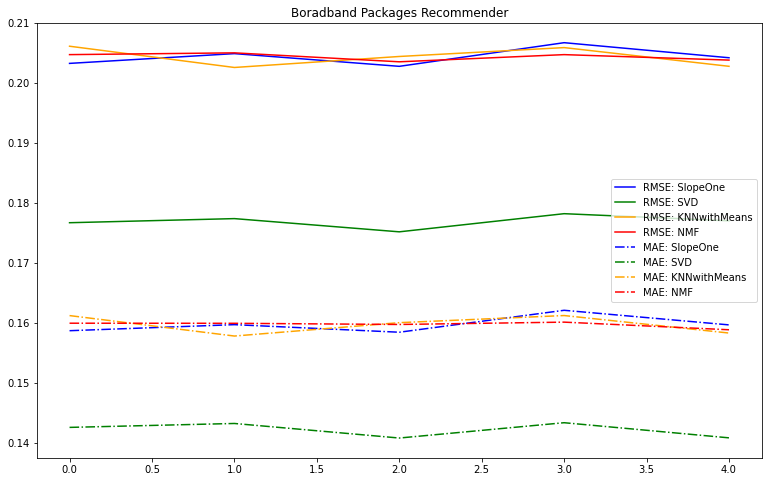

In [57]:
fig,ax = plt.subplots(figsize=(13,8))
ax.plot(so_validate["test_rmse"], color='blue')
ax.plot(svd_validate["test_rmse"], color='green')
ax.plot(knn_validate["test_rmse"], color='orange')
ax.plot(nmf_validate["test_rmse"], color='red')
ax.plot(so_validate["test_mae"], linestyle='dashdot', color='blue')
ax.plot(svd_validate["test_mae"], linestyle='dashdot', color='green')
ax.plot(knn_validate["test_mae"], linestyle='dashdot', color='orange')
ax.plot(nmf_validate["test_mae"], linestyle='dashdot', color='red')
# plt.xticks(np.arange(0, 30, 0.5))
plt.title("Boradband Packages Recommender", loc="center")
plt.legend(["RMSE: SlopeOne","RMSE: SVD","RMSE: KNNwithMeans","RMSE: NMF",
           "MAE: SlopeOne","MAE: SVD","MAE: KNNwithMeans","MAE: NMF"])

## Best Accuracy Model

In [61]:
data_triplet.mean()

ratings           0.407501
SVD_error         0.139953
SlopeOne_error    0.157890
MF_error          0.157890
KNNMeans_error    0.157890
dtype: float64

In [ ]:
# Best Accuracy model - SlopeOne

## Model Stacking approach (Ensambling)

## Busines Rule filtration

In [75]:
data_triplet = data_triplet.merge(user_profile[["ACCOUNT_NUM.hash","Sub_Update_Date","Sub_Update_Status","Sub_Update"]], on ="ACCOUNT_NUM.hash", how ="left")

In [78]:
# Filter results based on Package owngrades
def play_rule(rec_packages, sub_state,sub_update):
    if (not sub_update == "NO_INFO") or (not sub_update == "NO INFO"):
        prev_package = sub_update.split("->")[0].replace(" ","")
        for pack in rec_packages:
            if sub_state == "Promotion Downgrade" and pack == prev_package:
                return "ERR"

data_triplet["Err_Rec"] = data_triplet.apply(lambda x: play_rule([x["SVD_recommendation"],x["SlopeOne_recommendation"],x["MF_recommendation"],x["KNNMeans_recommendation"]],x["Sub_Update_Status"],x["Sub_Update"]), axis =1 )

In [81]:
data_triplet = data_triplet.drop(["Sub_Update_Date","Sub_Update_Status","Sub_Update"],axis=1)
data_triplet.head()

,ACCOUNT_NUM.hash,Actual_Subscription,ratings,SVD_recommendation,SVD_error,SlopeOne_recommendation,SlopeOne_error,MF_recommendation,MF_error,KNNMeans_recommendation,KNNMeans_error,Err_Rec
0,abfd56b8f14dfcf01b4163fa1e6bd975,DOUBLE_PLAY_PV,0.076656,DOUBLE_PLAY_PV,0.302884,DOUBLE_PLAY_PV,0.329940,DOUBLE_PLAY_PV,0.329940,DOUBLE_PLAY_PV,0.329940,None
1,2b0e4cbe7a58cc48263dd42510f15880,DOUBLE_PLAY_PV,0.119744,DOUBLE_PLAY_PV,0.259795,DOUBLE_PLAY_PV,0.286852,DOUBLE_PLAY_PV,0.286852,DOUBLE_PLAY_PV,0.286852,None
2,85f497dba91c0ea6fdd35e8c588708af,DOUBLE_PLAY_PV,0.326062,DOUBLE_PLAY_PV,0.053477,DOUBLE_PLAY_PV,0.080534,DOUBLE_PLAY_PV,0.080534,DOUBLE_PLAY_PV,0.080534,None
3,241f06474d8b8022dc3629fe804fbe93,TRIPLE_PLAY,0.199717,TRIPLE_PLAY,0.309947,TRIPLE_PLAY,0.206878,TRIPLE_PLAY,0.206878,TRIPLE_PLAY,0.206878,ERR
4,ea3460ef9ff0a231cce3ce2cbe722365,DOUBLE_PLAY_PV,0.391821,DOUBLE_PLAY_PV,0.012281,DOUBLE_PLAY_PV,0.014775,DOUBLE_PLAY_PV,0.014775,DOUBLE_PLAY_PV,0.014775,None


## Store resutls

In [82]:
data_triplet.to_csv("data/cross-selling/scored/CF_scored_and_eval.csv")